**Processing gsets and evaluating KL**

In [1]:
import sys
sys.path.append("/Users/djuna/Documents/ABCA7lof2")


In [2]:
import numpy as np
from tqdm.contrib.concurrent import process_map
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numba as nb
from sklearn.manifold import SpectralEmbedding
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
import seaborn as sns
import numba as nb
import numpy as np

from ABCA7lof2.geneclusters import compute_jaccard, compute_all_jaccard, get_rand_index, get_LP, get_spectral_partition, evaluate_cut, get_scores, compute_jaccard_all_clust, get_all_rands, get_all_rands2grps, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

/Users/djuna/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import urllib.request

output_dir = "../../processed_data/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = [
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/kl_loss.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/kl_labs.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/met_loss.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/met_labs.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/all_paths.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/leading_edge_0825Ex.csv',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/all_scores_0825.csv'
]
for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!
Download completed!
Download completed!
Download completed!
Download completed!
Download completed!
Download completed!


#### Subset matrix of interest

In [14]:
# subset matrix
mat = get_gene_pathway_matrix('../../processed_data/all_paths.npy')
leading_edge = '../../processed_data/leading_edge_0825Ex.csv'
leading_edge = pd.read_csv(leading_edge, index_col=0)
S = set(leading_edge['gene'])

col_index = np.where([x in S for x in mat.columns])[0]
mat_sub = mat.iloc[:,col_index]

path_index = (np.sum(mat_sub, axis=1)>4)
mat_sub = mat_sub.loc[path_index]
mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]

#### Plot Jaccard indices pre clustering

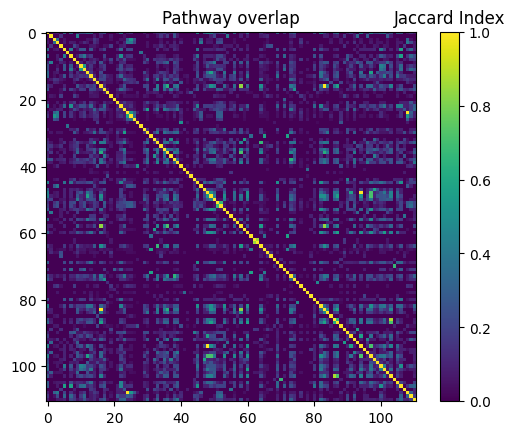

In [15]:
# get pathway gene matrix
mat_array = np.array(mat_sub)
out = compute_all_jaccard(mat_array)

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(out)

plt.imshow(out, cmap='viridis')
plt.colorbar()
plt.title('Pathway overlap')

cbar = plt.gcf().axes[-1]
cbar.set_title('Jaccard Index')

plt.savefig('../../paper/extended_plots/jaccard_mat_sub.png', bbox_inches='tight')

In [16]:
np.mean(np.sum(out>0, axis=0)/out.shape[0])

0.4286178069961854

### import the KL and metis partitions

In [17]:
kl_loss = np.load('../../processed_data/kl_loss.npy')
kl_labs = np.load('../../processed_data/kl_labs.npy')

In [18]:
metis_loss = np.load('../../processed_data/met_loss.npy')
metis_labs = np.load('../../processed_data/met_labs.npy')

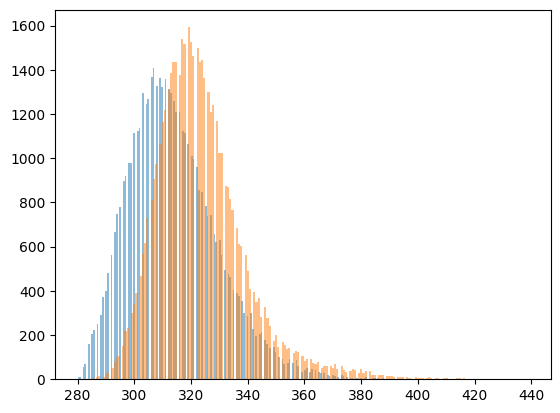

In [19]:
plt.hist(metis_loss, 200, alpha=0.5)
None
plt.hist(kl_loss, 200, alpha=0.5)
None

In [20]:
get_rand_index(kl_labs[np.argmin(kl_loss)], metis_labs[np.argmin(metis_labs)])

0.908702946930194

### spectral bissection

In [21]:
# compute laplacian matrix
full_mat = np.zeros((np.sum(mat_sub.shape), np.sum(mat_sub.shape)))
full_mat[mat_sub.shape[1]:][:,:mat_sub.shape[1]] = mat_sub
full_mat[:mat_sub.shape[1]][:,mat_sub.shape[1]:]=mat_sub.T

i=0
nclust = 8
it = int(np.log2(nclust))
labels_sp = np.zeros((nclust,full_mat.shape[0]))

for x in range(it):
    grps = np.unique(labels_sp, axis=1)
    index = [[np.unique(labels_sp[:,x]==grps[:,y])[0] for x in range(labels_sp.shape[1])] for y in range(grps.shape[1])]
    for j in range(len(index)):
        get_spectral_partition(labels_sp,  get_LP(full_mat[index[j]][:,index[j]]), i, index[j])
        i+=1
labels_sp = [np.argwhere(np.sum(np.unique(labels_sp, axis=1)-labels_sp[:,x].reshape(-1,1)==0, axis=0)==nclust)[0][0] for x in range(labels_sp.shape[1])] 
loss_sp = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

### spectral clustering

In [22]:
N=1000
loss_sc=np.empty(N)
labs_sc = np.zeros_like(kl_labs)
for i in tqdm(range(N)): 
    sc = SpectralClustering(8, assign_labels='kmeans', random_state=i, affinity='precomputed').fit(full_mat)
    loss_sc[i]=evaluate_cut(np.ascontiguousarray(mat_sub.values.T), sc.labels_, 0)
    labs_sc[i] = sc.labels_

100%|██████████| 1000/1000 [00:45<00:00, 21.78it/s]


### Random partitioning

In [23]:
labs_rand = kl_labs.copy()
loss_rand = np.empty(N)

for i in tqdm(range(N)):
    L = np.random.permutation(kl_labs[0])
    labs_rand[i] = L
    loss_rand[i] = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), L, 0)

100%|██████████| 1000/1000 [00:06<00:00, 156.46it/s]


### plot loss

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_3365/1578359199.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="loss", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")


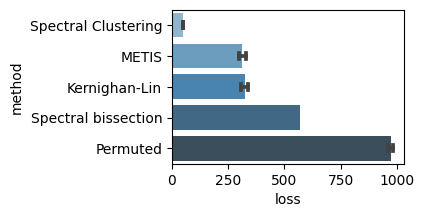

In [14]:
# plot loss by method for cluster size 8

df = pd.DataFrame(np.concatenate((loss_sc,metis_loss, kl_loss, np.array([loss_sp]), loss_rand)))
df['method'] = np.concatenate((np.repeat('Spectral Clustering', N),np.repeat('METIS', len(kl_loss)), (np.repeat('Kernighan-Lin', len(kl_loss))), ['Spectral bissection'], np.repeat('Permuted', N)))
df.columns = ['loss', 'method']

plt.figure(figsize=(3,2))

sns.barplot(data=df, x="loss", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")
plt.savefig('../../paper/extended_plots/partitioning_losses.pdf', bbox_inches='tight')

### Rand indices

In [15]:
N=1000

In [16]:
kl_RI = np.empty((N,N))
get_all_rands(kl_RI, N, kl_labs)

met_RI = np.empty((N,N))
get_all_rands(met_RI, N, metis_labs)

rand_RI = np.empty((N,N))
get_all_rands(rand_RI, N, labs_rand)


In [17]:
kl_metis_RI = np.empty((N,N))
get_all_rands2grps(kl_metis_RI, N, metis_labs, kl_labs)

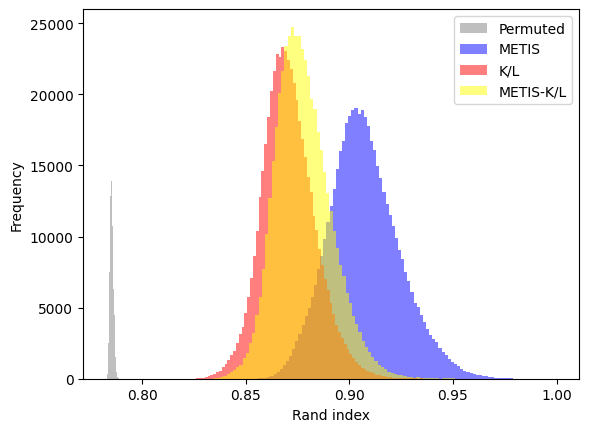

In [18]:
plt.hist(rand_RI[np.tril_indices_from(rand_RI, k=-1)],bins=100, color='grey', alpha=0.5, label='Permuted')
plt.hist(met_RI[np.tril_indices_from(met_RI, k=-1)],bins=100, color='blue', alpha=0.5, label = 'METIS')
plt.hist(kl_RI[np.tril_indices_from(kl_RI, k=-1)],bins=100, color='red', alpha=0.5, label = 'K/L')
plt.hist(kl_metis_RI[np.tril_indices_from(kl_metis_RI, k=-1)],bins=100, color='yellow', alpha=0.5, label = 'METIS-K/L')
plt.legend()
plt.xlabel('Rand index')
plt.ylabel('Frequency')

None


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_3365/3356164663.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="Rand index", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")


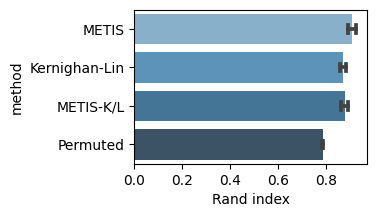

In [19]:
# plot rand by method for cluster size 8

df = pd.DataFrame(np.concatenate((met_RI[np.tril_indices_from(met_RI, k=-1)],kl_RI[np.tril_indices_from(kl_RI, k=-1)],kl_metis_RI[np.tril_indices_from(kl_metis_RI, k=-1)], rand_RI[np.tril_indices_from(rand_RI, k=-1)])))
n = len(kl_RI[np.tril_indices_from(kl_RI, k=-1)])
df['method'] = np.concatenate((np.repeat('METIS', n), np.repeat('Kernighan-Lin', n), np.repeat('METIS-K/L', n), np.repeat('Permuted', n)))
df.columns = ['Rand index', 'method']

plt.figure(figsize=(3,2))

sns.barplot(data=df, x="Rand index", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")
plt.savefig('../../paper/extended_plots/rand_indices.pdf', bbox_inches='tight')

#### Plot jaccard indices

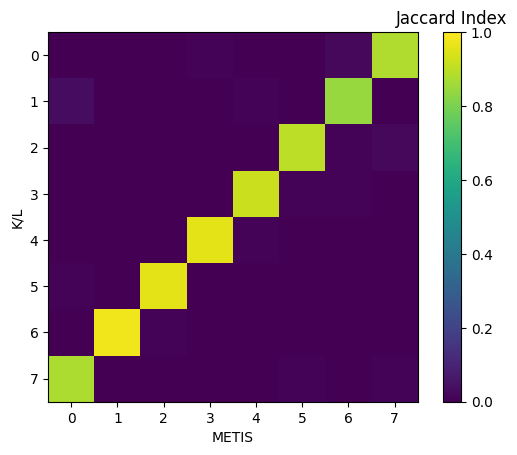

In [24]:
temp = compute_jaccard_all_clust(kl_labs[np.argmin(kl_loss)], metis_labs[np.argmin(metis_loss)])
T = temp

o = [7,1,4,6,0,3,2,5]
plt.imshow(temp[o].T, cmap='viridis', vmax=1, vmin=0)
plt.ylabel('K/L')
plt.xlabel('METIS')
plt.colorbar()

cbar = plt.gcf().axes[-1]
cbar.set_title('Jaccard Index')

plt.savefig('../../paper/extended_plots/argmins_jaccard.png', bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


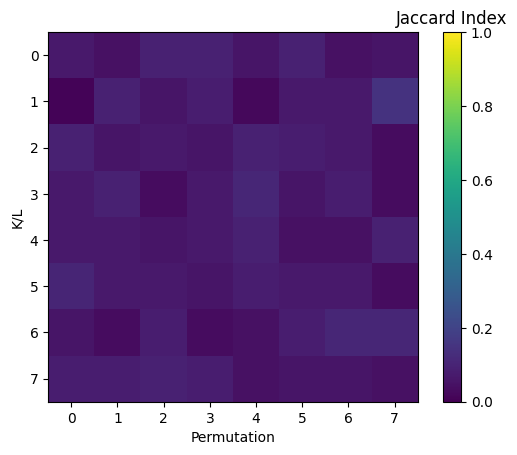

In [25]:
# plot jaccard for Kl_loss and rand permutation

temp = compute_jaccard_all_clust(kl_labs[np.argmin(kl_loss)], labs_rand[np.argmin(loss_rand)])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp, cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.ylabel('K/L')
plt.xlabel('Permutation')

cbar = plt.gcf().axes[-1]
cbar.set_title('Jaccard Index')

plt.savefig('../../paper/extended_plots/random_jaccard.png', bbox_inches='tight')

#### plot adjacency matrix for one example of each method

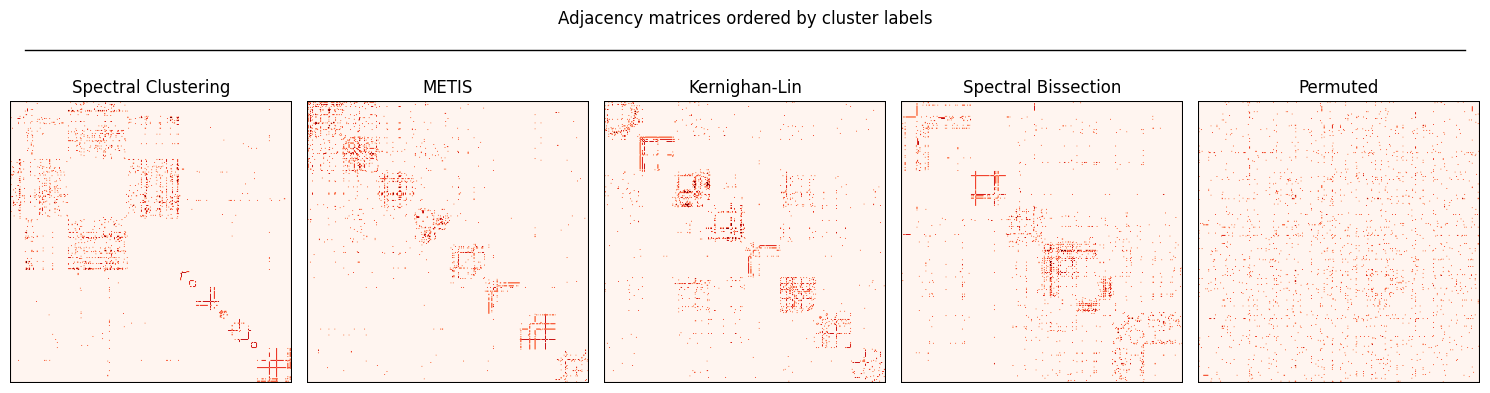

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

axes[0].imshow(full_mat[np.argsort(labs_sc[np.argmin(loss_sc)])][:, np.argsort(labs_sc[np.argmin(loss_sc)])],
               vmin=0, vmax=1, cmap='Reds')
axes[0].set_title('Spectral Clustering')
axes[0].axis('off')

axes[1].imshow(full_mat[np.argsort(metis_labs[np.argmin(metis_loss)])][:, np.argsort(metis_labs[np.argmin(metis_loss)])],
               vmin=0, vmax=1, cmap='Reds')
axes[1].set_title('METIS')
axes[1].axis('off')

axes[2].imshow(full_mat[np.argsort(kl_labs[np.argmin(kl_loss)])][:, np.argsort(kl_labs[np.argmin(kl_loss)])],
               vmin=0, vmax=1, cmap='Reds')
axes[2].set_title('Kernighan-Lin')
axes[2].axis('off')

axes[3].imshow(full_mat[np.argsort(labels_sp)][:, np.argsort(labels_sp)],
               vmin=0, vmax=1, cmap='Reds')
axes[3].set_title('Spectral Bissection')
axes[3].axis('off')

axes[4].imshow(full_mat[np.argsort(labs_rand[np.argmin(loss_rand)])][:, np.argsort(labs_rand[np.argmin(loss_rand)])],
               vmin=0, vmax=1, cmap='Reds')
axes[4].set_title('Permuted')
axes[4].axis('off')

plt.tight_layout()
fig.suptitle("Adjacency matrices ordered by cluster labels", fontsize=12, y=1)
from matplotlib.lines import Line2D
line = Line2D([0.02, 0.98], [0.9, .9], transform=fig.transFigure, color="black", linewidth=1)
fig.add_artist(line)
plt.subplots_adjust(top=.8)

from matplotlib.patches import Rectangle  # required for drawing the outlines

# Add a black border around each subplot to clearly outline each plot.
for ax in axes:
    # Create a rectangle patch that spans the entire axis (using Axes coordinates)
    rect = Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=1.5, edgecolor='black', facecolor='none'
    )
    ax.add_patch(rect)


fig.savefig('../../paper/extended_plots/adjacency_matrices_ordered_by_cluster_labels.pdf', bbox_inches='tight')



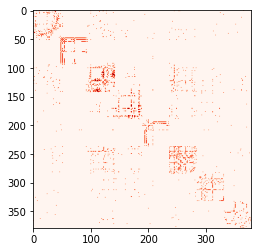

In [14]:
plt.imshow(full_mat[np.argsort(kl_labs[np.argmin(kl_loss)])][:,np.argsort(kl_labs[np.argmin(kl_loss)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_KL_cluster.pdf')

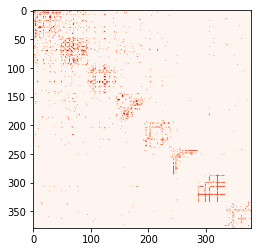

In [15]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(metis_labs[np.argmin(metis_loss)])][:,np.argsort(metis_labs[np.argmin(metis_loss)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_metis_cluster.pdf')

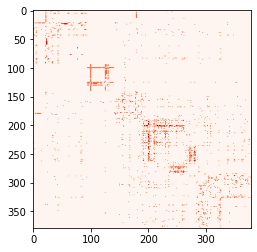

In [16]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labels_sp)][:,np.argsort(labels_sp)], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SP_cluster.pdf')

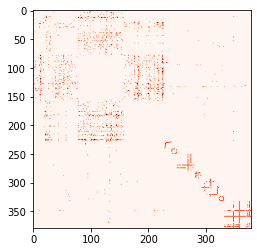

In [19]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labs_sc[np.argmin(loss_sc)])][:,np.argsort(labs_sc[np.argmin(loss_sc)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SC_cluster.pdf')

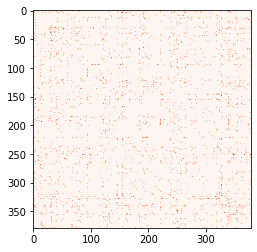

In [21]:
plt.imshow(full_mat[np.argsort(labs_rand[np.argmin(loss_rand)])][:,np.argsort(labs_rand[np.argmin(loss_rand)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_uniform_cluster.pdf')